In [1]:
import numpy as np
import matplotlib.pyplot as plt
import flpoAgent
import importlib
import random
from scipy.spatial.distance import cdist
import createEnv
from scipy.optimize import Bounds, LinearConstraint, minimize
import supporting_functions
from matplotlib.cm import get_cmap

n_waypoints: 6 
n_agents: 3 
CAT:
[10. 10. 10. 10. 10. 10.] 
b1:
[0.7 0.7 0.7 0.7 0.7 0.7] 
b2:
[0. 0. 0. 0. 0. 0.]
---------
wp_locations:
[[-6.39460622e+00 -9.61049517e+00]
 [ 4.99264371e+02  4.49867858e+00]
 [ 9.98404072e+02 -2.91458037e-01]
 [-9.74438371e+00  4.99747432e+02]
 [ 5.08836133e+02  5.07015902e+02]
 [ 1.00459929e+03  4.92174721e+02]] 
mask:
[[0 1 0 1 0 0]
 [1 0 1 0 1 0]
 [0 1 0 0 0 1]
 [1 0 0 0 1 0]
 [0 1 0 1 0 1]
 [0 0 1 0 1 0]] 
dist_mat:
[[1.00000000e+08 5.05855779e+02 1.00000000e+08 5.09368942e+02
  1.00000000e+08 1.00000000e+08]
 [5.05855779e+02 1.00000000e+08 4.99162686e+02 1.00000000e+08
  5.02608375e+02 1.00000000e+08]
 [1.00000000e+08 4.99162686e+02 1.00000000e+08 1.00000000e+08
  1.00000000e+08 4.92505146e+02]
 [5.09368942e+02 1.00000000e+08 1.00000000e+08 1.00000000e+08
  5.18631452e+02 1.00000000e+08]
 [1.00000000e+08 5.02608375e+02 1.00000000e+08 5.18631452e+02
  1.00000000e+08 4.95985250e+02]
 [1.00000000e+08 1.00000000e+08 4.92505146e+02 1.00000000e+08
  4

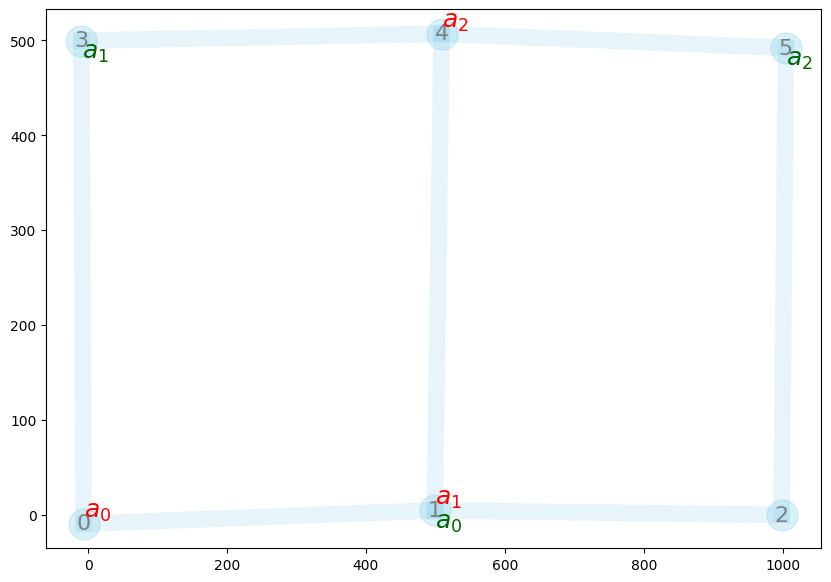

In [2]:
importlib.reload(flpoAgent)
importlib.reload(createEnv)
importlib.reload(supporting_functions)

# generate waypoints and the adjacency matrix
n_waypoints = 6
n_agents = 3
tolArray = np.random.uniform(10, 10, n_waypoints)
b1 = np.ones(n_waypoints)*0.7
b2 = np.ones(n_waypoints)*0.0

# Grid network parameters
grid_params = {
    'type':'grid',
    'n_points':n_waypoints,
    'grid_size':1000,
    'noise_factor':10
}

# Ring network parameters
ring_params = {
    'type':'ring',
    'num_rings':3,
    'points_per_ring':int(n_waypoints/3),
    'center_distance':200,
    'deformation_level':50.0,
    'extra_connections':0.00,
    'missing_connections':0.05
}

# create a mars environment
mars = createEnv.MARS(
    n_waypoints, 
    n_agents, 
    tolArray, 
    b1, 
    b2, 
    grid_params, 
    seed=11, 
    printFlag=True)

# compute conflict cost
beta0=1e-8
gamma_t = 5e0
gamma_c = 1e-2
coeff_t = 50
coeff_c = 0.01
# calculate conflict cost
# print(f'mars_schedule:\n{np.round(mars.sched_mat,2)}')
# Xi = mars.agents[1].returnStageWiseCost(mars.sched_mat[1,:], mars.dist_mat, gamma_t, coeff_t)
# Pb = mars.agents[1].getPathAssociations(mars.sched_mat[1,:], mars.dist_mat, beta0, gamma_t, coeff_t)
# print(f'agent start:{mars.agents[1].s}\nprobability:\n{Pb[1]}\nstageWiseCost:{Xi[1]}')

reach_mat = mars.calc_agent_reach_mat(
        mars.sched_mat, 
        beta=beta0, gamma=gamma_t, coeff=coeff_t)
filter_wp = np.ones(shape=reach_mat.shape)
filter_wp[reach_mat <= 1.0e-10] = 0.0 
print(f'reach_mat')
print(f'filter_wp:\n{filter_wp}')
mars.transportCost(mars.sched_mat, beta=beta0, gamma=gamma_t, coeff=coeff_t)
print(f'transport_cost:\n{mars.C_agents}')
mars.conflictCost(mars.sched_mat, gamma=gamma_c, coeff=coeff_c, filter_wp=filter_wp)
print(f'conflict_cost:\n{mars.C_wp_conflict}')

# mars visualization
# agent_routes, agent_schedules, agent_colors = createEnv.calc_agent_routes_and_schedules(mars, Pb_a=[], printRoutes=False)
cmap = get_cmap('tab20')
agent_colors = {a: cmap(i / mars.n_agents) for i, a in enumerate(range(mars.n_agents))}
createEnv.plotNetwork(mars=mars, figuresize=(10,7), routes=[], agent_colors=agent_colors, showEdgeLength=False, plotPaths=False)

# agent visualization
show_graph=0
if show_graph:
    for i,v in enumerate(mars.agents):
        v.showGraph(mars.wp_locations, mars.dist_mat, mars.mask, mars.sched_mat[i,:], figuresize=(10,5), showEdgeTimeLim=True) 



### Write a code to flatten the scheduling matrix row-wise ($y$) and column-wise ($z$) and construct a linear transformation between them $A$.

In [3]:
def compute_transformation_matrix(rows, cols):
    # Total number of elements
    n = rows * cols

    # Create a basis for all standard basis vectors in column-wise (z) order
    A = np.zeros((n, n))

    for i in range(n):
        # Create one-hot vector in column-wise order
        z = np.zeros((rows, cols))
        # Get the (row, col) index for column-wise flattening
        row = i % rows
        col = i // rows
        z[row, col] = 1

        # Flatten row-wise to get the i-th column of A
        y = z.flatten(order='C')  # 'C' means row-major
        A[:, i] = y

    return A

# compute transformation
Azy = compute_transformation_matrix(mars.n_agents, mars.n_waypoints)
# verify
Tmat = mars.sched_mat
y = Tmat.flatten()
z = (Tmat.T).flatten()
err1 = y - Azy @ z
err2 = Azy.T @ y - z
err3 = np.max(np.abs(Azy.T @ Azy - np.eye(mars.n_agents * mars.n_waypoints)))

# print("Transformation matrix A:z-->y\n", Azy)
# print(f'norms:\tres1 {np.linalg.norm(res1)}\tres2 {np.linalg.norm(res2)}\tres3 {np.linalg.norm(res3)}')


### Formulate and solve the ADMM optimization problem

In [4]:
def lagrangian_y(y, mars, zk, lk, Azy, beta, gamma, coeff, rho=0.1):
    Tmat = y.reshape(-1, mars.n_waypoints)
    mars.transportCost(Tmat, beta, gamma, coeff) # function y
    phi1_y = np.sum(mars.C_agents)
    linear_term = lk @ y
    quadratic_term = rho/2 * np.linalg.norm(y - Azy @ zk)**2
    # print(f'{type(phi1_y), type(linear_term), type(quadratic_term)}')
    cost = phi1_y + linear_term + quadratic_term
    return cost

def lagrangian_z(z, mars, yk1, lk, Azy, gamma, coeff, rho=0.1):
    Tmat = z.reshape(-1, mars.n_agents).T
    mars.conflictCost1(Tmat, gamma, coeff)
    phi2_z = np.sum(mars.C_wp_conflict)
    linear_term = -lk @ (Azy @ z)
    quadratic_term = rho/2 * np.linalg.norm(yk1 - Azy @ z)**2
    cost = phi2_z + linear_term + quadratic_term
    return cost

def update_dual(lk, yk1, zk1, Azy, rho=0.1):
    lk1 = lk + rho * (yk1 - Azy @ zk1)
    return lk1


### Code to perform the ADMM iterations in loop

In [5]:
lb0 = np.zeros(mars.n_agents * mars.n_waypoints)
ub0 = 100 * np.ones(mars.n_agents * mars.n_waypoints)
bounds = Bounds(lb0, ub0)

yk = Tmat.flatten()
zk = (Tmat.T).flatten() + np.random.multivariate_normal(np.zeros(y.shape), 1e-3 * np.eye(y.shape[0]))
lk = np.random.uniform(0.0, 10.0, (y.shape))
beta = 1e1
gamma = 7
coeff = 1
rho = 0.1
norm_yz_arr = []

n_iters_admm = 20
for i in range(n_iters_admm):

    # update y given (yk, zk, lk)
    yk1 = minimize(
        lagrangian_y,
        yk,
        args = (mars, zk, lk, Azy, beta, gamma, coeff, rho),
        method='slsqp',
        bounds = bounds,
        options={'disp':0}
    ).x

    # update z given (yk1, zk, lk)
    zk1 = minimize(
        lagrangian_z,
        z,
        args = (mars, yk1, lk, Azy, gamma, coeff, rho),
        method='slsqp',
        bounds = bounds,
        options={'disp':0}
    ).x

    # update l given (yk1, zk1, lk)
    lk1 = update_dual(lk, yk1, zk1, Azy, rho)

    norm_yz = np.max(np.abs(yk1 - Azy @ zk1))
    norm_yz_arr.append(norm_yz)
    print(f'i:{i}\tnorm_yz: {norm_yz:.4f}')

    yk = yk1
    zk = zk1
    lk = lk1

i:0	norm_yz: 98.7135
i:1	norm_yz: 14.4304
i:2	norm_yz: 11.0735
i:3	norm_yz: 3.4659
i:4	norm_yz: 1.8404
i:5	norm_yz: 5.5570
i:6	norm_yz: 8.5146
i:7	norm_yz: 5.4185
i:8	norm_yz: 1.2740
i:9	norm_yz: 0.2112
i:10	norm_yz: 0.4003
i:11	norm_yz: 1.0055
i:12	norm_yz: 1.4800
i:13	norm_yz: 8.2250
i:14	norm_yz: 4.8202
i:15	norm_yz: 4.0683
i:16	norm_yz: 6.5436
i:17	norm_yz: 4.1249
i:18	norm_yz: 6.3563
i:19	norm_yz: 4.6580


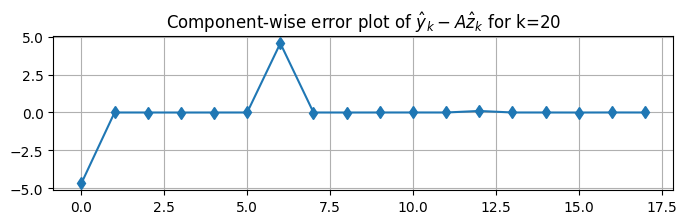

In [6]:
error_final = yk1 - Azy @ zk1
plt.figure(figsize=(8,2))
plt.plot(error_final, marker='d')
plt.title(rf'Component-wise error plot of $\hat y_k-A \hat z_k$ for k={n_iters_admm}')
plt.grid()
plt.show()

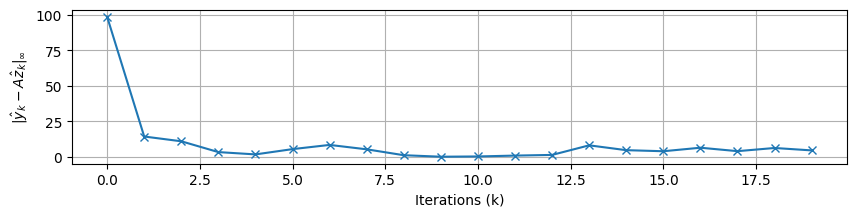

In [7]:
plt.figure(figsize=(10,2))
plt.plot(norm_yz_arr, marker='x')
plt.xlabel('Iterations (k)')
plt.ylabel(rf'$|\hat y_k - A \hat z_k|_\infty$')
plt.grid()
# plt.legend()
plt.show()

### Code to perform Annealing with ADMM iterations